Two most common types of recommender systems are *content based* and *collaborative filtering*

Collaborative filtering produces recommendations based on the knowledge of users' attitudes towards items.  It uses the 'wisdom of the crowd' to recommend items (e.g. Amazon)

Content-based systems focus on the attributes of the items and give you recommendations based on the similarity between them.

Collaborative filtering tends to be more popular because it usually gives better results and is relatively easy to understand.  The algorithm can also do feature learning on its own when more data is introduced.

CF can be broken into Memory-Based CF and Model-Based CF.  The advanced module shows Model-Based CF with Singular Value Decomposition (SVD) and Memory-Based CF using cosine similarity.

Note that there are more practice datasets in the bootcamp version of this notebook.

In [1]:
import os
os.chdir('C:\\Users\\casey\\Downloads\\Python-Data-Science-and-Machine-Learning-Bootcamp-master\\Machine Learning Sections\\Recommender-Systems')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# since we know which columns we are using, we can create column names manually

column_names = ['user_id', 'item_id', 'rating', 'timestamp']

In [4]:
df = pd.read_csv('u.data', sep = '\t', names = column_names) # data is separated by tabs, hence sep = '\t'

In [5]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


In [6]:
movie_titles = pd.read_csv('Movie_Id_Titles')

In [7]:
movie_titles.head()

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [9]:
df = pd.merge(df, movie_titles, on = 'item_id')

In [10]:
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [11]:
sns.set_style('whitegrid')

In [13]:
# highest and lowest rated movies

df.groupby('title')['rating'].mean().sort_values(ascending = False)

title
Marlene Dietrich: Shadow and Light (1996)                 5.000000
Prefontaine (1997)                                        5.000000
Santa with Muscles (1996)                                 5.000000
Star Kid (1997)                                           5.000000
Someone Else's America (1995)                             5.000000
Entertaining Angels: The Dorothy Day Story (1996)         5.000000
Saint of Fort Washington, The (1993)                      5.000000
Great Day in Harlem, A (1994)                             5.000000
They Made Me a Criminal (1939)                            5.000000
Aiqing wansui (1994)                                      5.000000
Pather Panchali (1955)                                    4.625000
Anna (1996)                                               4.500000
Everest (1998)                                            4.500000
Maya Lin: A Strong Clear Vision (1994)                    4.500000
Some Mother's Son (1996)                                

In [14]:
# most and least reviewed movies

df.groupby('title')['rating'].count().sort_values(ascending = False)

title
Star Wars (1977)                                     584
Contact (1997)                                       509
Fargo (1996)                                         508
Return of the Jedi (1983)                            507
Liar Liar (1997)                                     485
English Patient, The (1996)                          481
Scream (1996)                                        478
Toy Story (1995)                                     452
Air Force One (1997)                                 431
Independence Day (ID4) (1996)                        429
Raiders of the Lost Ark (1981)                       420
Godfather, The (1972)                                413
Pulp Fiction (1994)                                  394
Twelve Monkeys (1995)                                392
Silence of the Lambs, The (1991)                     390
Jerry Maguire (1996)                                 384
Chasing Amy (1997)                                   379
Rock, The (1996)         

In [16]:
# create new ratings dataframe

ratings = pd.DataFrame(df.groupby('title')['rating'].mean())

In [17]:
# add number of ratings to data

ratings['num_ratings'] = df.groupby('title')['rating'].count()

In [18]:
ratings.head()

,rating,num_ratings
title,,
'Til There Was You (1997),2.333333,9
1-900 (1994),2.600000,5
101 Dalmatians (1996),2.908257,109
12 Angry Men (1957),4.344000,125
187 (1997),3.024390,41


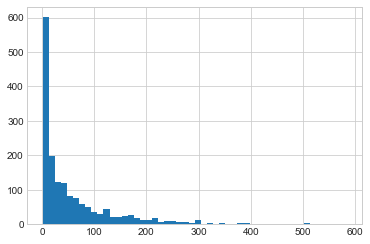

In [20]:
ratings['num_ratings'].hist(bins = 50)

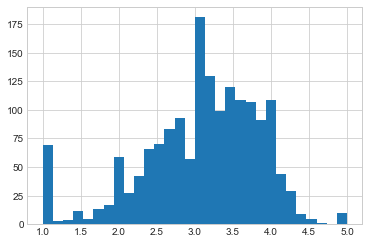

In [23]:
# most movies have a small number of ratings
# now for ratings - centered around 3 with a good amount of outliers (especially near the bottom)

ratings['rating'].hist(bins = 30)

C:\Users\casey\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\casey\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


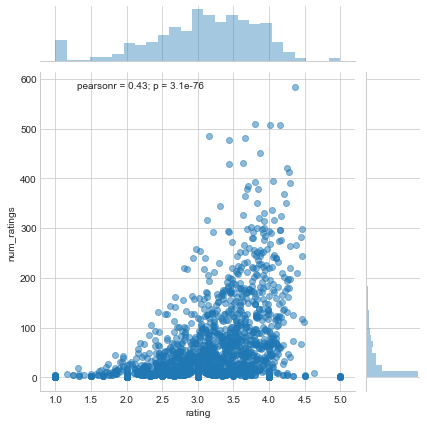

In [24]:
# relationship between average rating and number of ratings

sns.jointplot(x = 'rating', y = 'num_ratings', data = ratings, alpha = 0.5)

In [25]:
# time to create recommender system
# create a matrix so we can work with the data

moviemat = df.pivot_table(index = 'user_id', columns = 'title', values = 'rating')

In [26]:
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",...,Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# most values are NaN because most users have not rated most movies (sparse matrix)

ratings.sort_values('num_ratings', ascending = False)

,rating,num_ratings
title,,
Star Wars (1977),4.359589,584
Contact (1997),3.803536,509
Fargo (1996),4.155512,508
Return of the Jedi (1983),4.007890,507
Liar Liar (1997),3.156701,485
"English Patient, The (1996)",3.656965,481
Scream (1996),3.441423,478
Toy Story (1995),3.878319,452
Air Force One (1997),3.631090,431


In [28]:
# lets use Star Wars and Liar Liar as an example

starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

In [32]:
print(starwars_user_ratings.head())
print('\n')
print(liarliar_user_ratings.head())

user_id
0    5.0
1    5.0
2    5.0
3    NaN
4    5.0
Name: Star Wars (1977), dtype: float64


user_id
0    NaN
1    NaN
2    1.0
3    2.0
4    5.0
Name: Liar Liar (1997), dtype: float64


In [34]:
# use corrwith on moviemat and star wars ratings to compute pairwise correlation of rows or columns in a DataFrame

similar_to_starwars = moviemat.corrwith(starwars_user_ratings)

C:\Users\casey\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\casey\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [35]:
similar_to_starwars.head(10)

title
'Til There Was You (1997)                      0.872872
1-900 (1994)                                  -0.645497
101 Dalmatians (1996)                          0.211132
12 Angry Men (1957)                            0.184289
187 (1997)                                     0.027398
2 Days in the Valley (1996)                    0.066654
20,000 Leagues Under the Sea (1954)            0.289768
2001: A Space Odyssey (1968)                   0.230884
3 Ninjas: High Noon At Mega Mountain (1998)         NaN
39 Steps, The (1935)                           0.106453
dtype: float64

In [36]:
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

C:\Users\casey\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3175: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\casey\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)


In [37]:
similar_to_liarliar.head(10)

title
'Til There Was You (1997)                      0.118913
1-900 (1994)                                        NaN
101 Dalmatians (1996)                          0.469765
12 Angry Men (1957)                            0.066272
187 (1997)                                     0.175145
2 Days in the Valley (1996)                    0.040739
20,000 Leagues Under the Sea (1954)           -0.027932
2001: A Space Odyssey (1968)                  -0.057864
3 Ninjas: High Noon At Mega Mountain (1998)         NaN
39 Steps, The (1935)                           0.400918
dtype: float64

In [38]:
# clean by removing null values

corr_starwars = pd.DataFrame(similar_to_starwars, columns = ['Correlation'])
corr_starwars.dropna(inplace = True)

In [39]:
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [40]:
# highest correlated movies with Star Wars

corr_starwars.sort_values('Correlation', ascending = False).head(10)

,Correlation
title,
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Man of the Year (1995),1.0
Hollow Reed (1996),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Good Man in Africa, A (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


In [41]:
# many of these results don't make sense

# this is likely from one person who rated Star Wars 5 stars and each of these movies 5 stars as well

# to fix this, we can set a threshold for number of ratings a movie must have to be included in model

# join number of ratings with the Star Wars correlation dataset

# note that join is used instead of merge because the movie title is already the index

corr_starwars = corr_starwars.join(ratings['num_ratings'])

In [42]:
corr_starwars.head()

,Correlation,num_ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [44]:
# only keep results where there are at least 100 ratings

corr_starwars[corr_starwars['num_ratings'] > 100].sort_values('Correlation', ascending = False).head(20)

,Correlation,num_ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130
"Sting, The (1973)",0.367538,241
Indiana Jones and the Last Crusade (1989),0.350107,331
Pinocchio (1940),0.347868,101
"Frighteners, The (1996)",0.332729,115


In [45]:
# Now the results seem to make a lot more sense 

# Let's move onto Liar Liar

corr_liarliar = pd.DataFrame(similar_to_liarliar, columns = ['Correlation'])

In [47]:
corr_liarliar.head()

,Correlation
title,
'Til There Was You (1997),0.118913
1-900 (1994),NaN
101 Dalmatians (1996),0.469765
12 Angry Men (1957),0.066272
187 (1997),0.175145


In [48]:
# remove NaN values

corr_liarliar.dropna(inplace = True)

In [50]:
# join number of ratings

corr_liarliar = corr_liarliar.join(ratings['num_ratings'])

In [52]:
corr_liarliar[corr_liarliar['num_ratings'] > 100].sort_values('Correlation', ascending = False).head(20)

,Correlation,num_ratings
title,,
Liar Liar (1997),1.000000,485
Batman Forever (1995),0.516968,114
"Mask, The (1994)",0.484650,129
Down Periscope (1996),0.472681,101
Con Air (1997),0.469828,137
Pretty Woman (1990),0.469790,164
101 Dalmatians (1996),0.469765,109
Michael (1996),0.442022,119
Waterworld (1995),0.438405,102
